### Baseline Text Classification Model for All the News Dataset
Goal: Do data prep for baseline text classification

#### Import librarires

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc
import spacy
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/curtispond/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Load and inspect the data

In [3]:
# We will load the full data set to start our baseline text classification model
df = pd.read_csv('./data/all-the-news-2-1.csv')

In [4]:
df.head(10)

,date,year,month,day,author,title,article,url,section,publication
0,2016-12-09 18:31:00,2016,12.0,9,Lee Drutman,We should take concerns about the health of li...,"This post is part of Polyarchy, an independent...",https://www.vox.com/polyarchy/2016/12/9/138983...,NaN,Vox
1,2016-10-07 21:26:46,2016,10.0,7,Scott Davis,Colts GM Ryan Grigson says Andrew Luck's contr...,The Indianapolis Colts made Andrew Luck the h...,https://www.businessinsider.com/colts-gm-ryan-...,NaN,Business Insider
2,2018-01-26 00:00:00,2018,1.0,26,NaN,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",https://www.reuters.com/article/us-davos-meeti...,Davos,Reuters
3,2019-06-27 00:00:00,2019,6.0,27,NaN,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,https://www.reuters.com/article/france-politic...,World News,Reuters
4,2016-01-27 00:00:00,2016,1.0,27,NaN,Paris Hilton: Woman In Black For Uncle Monty's...,Paris Hilton arrived at LAX Wednesday dressed ...,https://www.tmz.com/2016/01/27/paris-hilton-mo...,NaN,TMZ
5,2019-06-17 00:00:00,2019,6.0,17,NaN,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",https://www.reuters.com/article/ecb-policy-coe...,Financials,Reuters
6,2019-06-23 00:00:00,2019,6.0,23,NaN,"Venezuela detains six military, police officia...",CARACAS (Reuters) - Venezuelan authorities hav...,https://www.reuters.com/article/us-venezuela-p...,World News,Reuters
7,2018-05-02 17:09:00,2018,5.0,2,Caroline Williams,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,https://www.vice.com/en_us/article/9kgp4v/how-...,Health,Vice
8,2016-05-18 13:00:06,2016,5.0,18,Mark Bergen,How to watch the Google I/O keynote live,"Google I/O, the company's big developer confer...",https://www.vox.com/2016/5/18/11697070/how-to-...,NaN,Vox
9,2017-03-02 00:00:00,2017,3.0,2,Tim Hume,China is dismissing unfavorable media reports ...,China is dismissing unfavorable media reports ...,https://news.vice.com/en_us/article/xwvj7j/chi...,NaN,Vice News


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688878 entries, 0 to 2688877
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   year         int64  
 2   month        float64
 3   day          int64  
 4   author       object 
 5   title        object 
 6   article      object 
 7   url          object 
 8   section      object 
 9   publication  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 205.1+ MB


In [6]:
# Count NaN values in each column
df.isnull().sum()

date                 0
year                 0
month                0
day                  0
author         1021101
title               37
article         104713
url              12577
section         912273
publication      12577
dtype: int64

We will need to convert data to a proper date data type. There are 100K articles that are null.

<AxesSubplot: title={'center': 'Top 20 Article Sections'}>

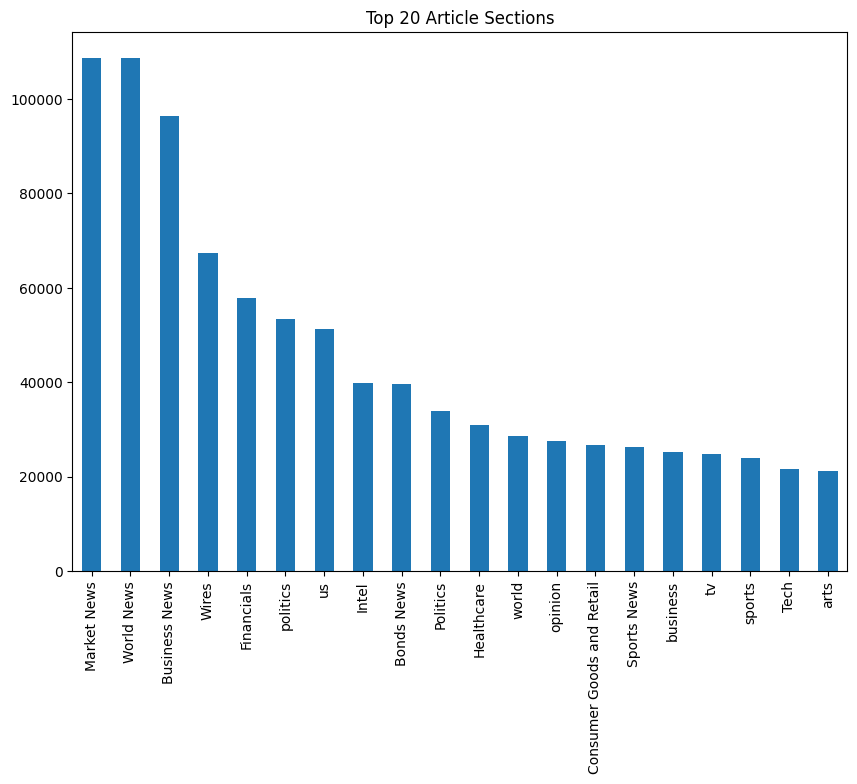

In [7]:
# Show the number of articles in each section
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Top 20 Article Sections')

In [9]:
# How many different section are there?
df['section'].nunique()

7509

#### Preprocess the data
1. Drop the author and url columns
2. Convert date to correct data type
3. Remove rows where article = NaN
4. Remove rows where section = NaN

In [5]:
# Drop the author and url columns
df.drop(columns=['author', 'url'], inplace=True)
df.shape

(2688878, 8)

In [6]:
# Convert the data column to the datetime format
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2688878 entries, 0 to 2688877
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   year         int64         
 2   month        float64       
 3   day          int64         
 4   title        object        
 5   article      object        
 6   section      object        
 7   publication  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 164.1+ MB


In [7]:
# Remove rows where Article is NaN
df.dropna(subset=['article'], inplace=True)

In [8]:
# Remove rows where Section is NaN
df.dropna(subset=['section'], inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753411 entries, 2 to 2688818
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   year         int64         
 2   month        float64       
 3   day          int64         
 4   title        object        
 5   article      object        
 6   section      object        
 7   publication  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 120.4+ MB


In [10]:
# Count the number of articles and sections with a NaN value
df.isnull().sum()


date           0
year           0
month          0
day            0
title          1
article        0
section        0
publication    0
dtype: int64

In [11]:
df.shape

(1753411, 8)

In [12]:
df.head()

,date,year,month,day,title,article,section,publication
2,2018-01-26 00:00:00,2018,1.0,26,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",Davos,Reuters
3,2019-06-27 00:00:00,2019,6.0,27,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,World News,Reuters
5,2019-06-17 00:00:00,2019,6.0,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",Financials,Reuters
6,2019-06-23 00:00:00,2019,6.0,23,"Venezuela detains six military, police officia...",CARACAS (Reuters) - Venezuelan authorities hav...,World News,Reuters
7,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,Health,Vice


In [13]:
# Reset the index
df.reset_index(drop=True, inplace=True)
df.head()

,date,year,month,day,title,article,section,publication
0,2018-01-26 00:00:00,2018,1.0,26,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",Davos,Reuters
1,2019-06-27 00:00:00,2019,6.0,27,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,World News,Reuters
2,2019-06-17 00:00:00,2019,6.0,17,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",Financials,Reuters
3,2019-06-23 00:00:00,2019,6.0,23,"Venezuela detains six military, police officia...",CARACAS (Reuters) - Venezuelan authorities hav...,World News,Reuters
4,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,Health,Vice


#### Create a data frame with Business, Entertainment, Sports, Healthcare, and Technology. 

<AxesSubplot: title={'center': 'Top 20 Article Sections in 10K Sample'}>

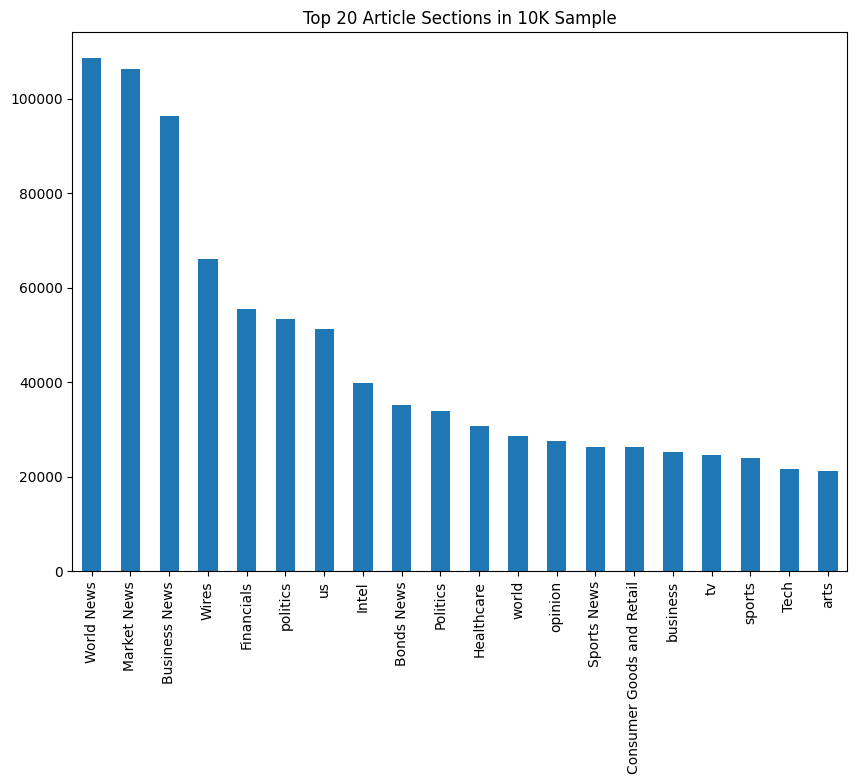

In [14]:
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Top 20 Article Sections in 10K Sample')

In [15]:
# Normalize the section names using the df_small test set
df['section'] = df['section'].str.lower()

In [16]:
# Update the section names to be more consistent
df['section'] = df['section'].replace('sports news', 'sports')
df['section'] = df['section'].replace('business news', 'business')

In [18]:
# Show  all sections that are like movies
df[df['section'].str.contains('movies')]

,date,year,month,day,title,article,section,publication
277148,2018-04-16 11:36:00,2018,4.0,16,Why John Oliver Bought a Jockstrap Worn By Rus...,John Oliver has a special treat in store for t...,movies,People
277270,2017-12-17 17:02:00,2017,12.0,17,Angelina Jolie Brings Maddox and Shiloh to Mus...,Angelina Jolie had quite a squad for her night...,movies,People
277287,2019-01-17 13:55:00,2019,1.0,17,Joe Alwyn Says It's 'Normal' to Be Private Abo...,Joe Alwyn isn’t sweating any commentary about ...,movies,People
277330,2019-01-06 23:37:00,2019,1.0,6,2019 Golden Globes: Rami Malek Wins Best Actor...,Rami Malek thanked a lot of people after winni...,movies,People
277392,2018-03-02 09:00:00,2018,3.0,2,Why Oprah Winfrey Left Money All Over Her Hote...,Oprah Winfrey had a special surprise for a luc...,movies,People
...,...,...,...,...,...,...,...,...
1752254,2020-03-20 08:00:06,2020,3.0,20,‘The Hunt’ Showdown: 7 Months of Training; 7 M...,Betty Gilpin and Hilary Swank worked with stun...,movies,The New York Times
1752255,2020-03-25 15:17:59,2020,3.0,25,‘The Occupant’ Review: Knock First,Streaming Movie Review A once-successful man b...,movies,The New York Times
1752257,2020-03-26 08:43:14,2020,3.0,26,‘The Platform’ Review: An Accidentally Timely ...,Streaming Movie Review Netflix’s gnarly class ...,movies,The New York Times
1752264,2020-03-27 03:01:04,2020,3.0,27,‘Uncorked’ Review: A Fresh Take on the Father-...,Streaming Movie Review A young man seeks to be...,movies,The New York Times


In [19]:
# Show  all sections that are like healthcare or tech
df[df['section'].str.contains('health|tech')]

,date,year,month,day,title,article,section,publication
4,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,health,Vice
20,2018-10-05 19:35:00,2018,10.0,5,Trash Geyser Spews Garbage In Yellowstone Nati...,Geyser eruptions are known as one of the most...,tech by vice,Vice
30,2019-06-20 00:00:00,2019,6.0,20,"Hungary has no evidence of Huawei threat, plan...",BUDAPEST (Reuters) - Hungary has no evidence t...,technology news,Reuters
40,2019-06-20 00:00:00,2019,6.0,20,Philippines' Globe Telecoms launches 5G servic...,MANILA (Reuters) - Philippines’ Globe Telecom ...,technology news,Reuters
49,2017-11-09 21:24:00,2017,11.0,9,Twitter Verification Has Always Been a Mess,Twitter wants to fix its long-broken verifica...,tech by vice,Vice
...,...,...,...,...,...,...,...,...
1753388,2020-03-31 00:00:00,2020,3.0,31,Popular livestreaming software Streamlabs OBS ...,Streaming is bigger than ever now that staying...,tech,The Verge
1753389,2020-03-31 00:00:00,2020,3.0,31,"Roku OS 9.3 adds faster performance, Spanish v...",Roku is today announcing the latest software u...,tech,The Verge
1753390,2020-03-31 00:00:00,2020,3.0,31,The Fitbit Charge 4 is a more powerful fitness...,The first Fitbit after Google announced it int...,tech,The Verge
1753392,2020-03-31 00:00:00,2020,3.0,31,Intel has its laptop work cut out this year,Even if you would never see yourself buying a ...,tech,The Verge


In [20]:
df['section'] = df['section'].replace('health', 'healthcare')
df['section'] = df['section'].replace('healthcarecare', 'healthcare')
df['section'] = df['section'].replace('hosptial',  'healthcare')
df['section'] = df['section'].replace('hospital',  'healthcare')
df['section'] = df['section'].replace('medical',  'healthcare')
df['section'] = df['section'].replace('medicare',  'healthcare')
df['section'] = df['section'].replace('medicaid',  'healthcare')
df['section'] = df['section'].replace('medication',  'healthcare')
df['section'] = df['section'].replace('medications',  'healthcare')

In [21]:
df['section'] = df['section'].replace('tech', 'technology')
df['section'] = df['section'].replace('science and technology', 'technology')
df['section'] = df['section'].replace('technology news', 'technology')
df['section'] = df['section'].replace('technology and science', 'technology')
df['section'] = df['section'].replace('technology and innovation', 'technology')
df['section'] = df['section'].replace('technology and computing', 'technology')
df['section'] = df['section'].replace('technology and engineering', 'technology')

<AxesSubplot: title={'center': 'Top 20 Article Sections'}>

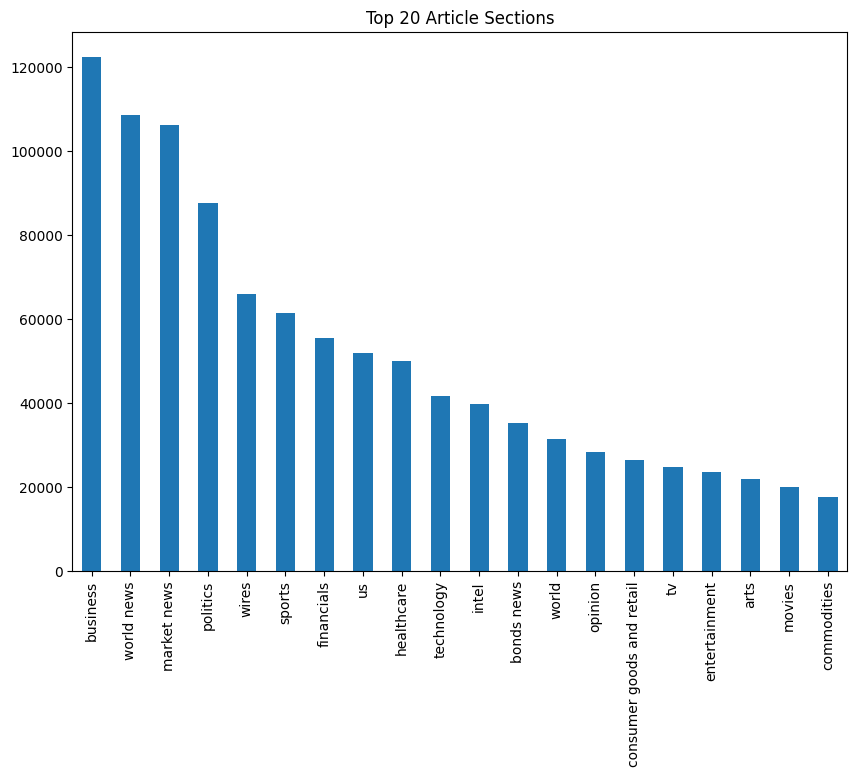

In [22]:
df['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Top 20 Article Sections')

In [29]:
df_small = df.groupby('section').head(5000)

In [30]:
df_model = df_small[df_small['section'].isin(['business', 'sports', 'technology', 'healthcare', 'movies'])]
df_model.shape

(25000, 8)

In [31]:
df_model.head()

,date,year,month,day,title,article,section,publication
4,2018-05-02 17:09:00,2018,5.0,2,You Can Trick Your Brain Into Being More Focused,If only every day could be like this. You can’...,healthcare,Vice
5,2019-06-23 00:00:00,2019,6.0,23,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,business,Reuters
9,2018-12-28 00:00:00,2018,12.0,28,Wells Fargo to pay $575 million in settlement ...,NEW YORK (Reuters) - Wells Fargo & Co (WFC.N) ...,business,Reuters
11,2019-05-21 00:00:00,2019,5.0,21,Factbox: Investments by automakers in the U.S....,(Reuters) - Major automakers have announced a ...,business,Reuters
12,2019-02-05 00:00:00,2019,2.0,5,Exclusive: Britain's financial heartland unbow...,LONDON (Reuters) - Britain’s financial service...,business,Reuters


In [32]:
# Reset the index
df_model.reset_index(drop=True, inplace=True)

<AxesSubplot: title={'center': 'Top 20 Article Sections in 10K Sample'}>

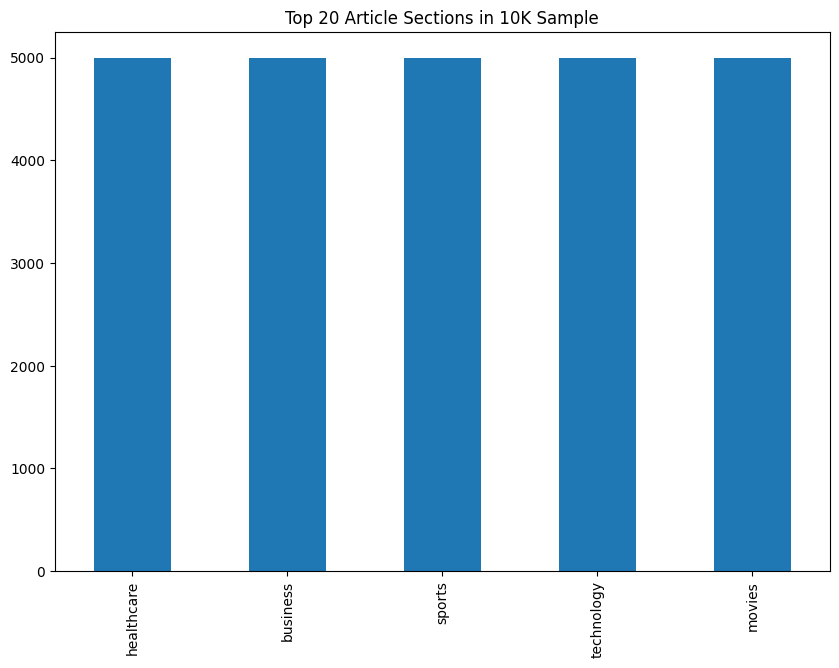

In [33]:
# Show the number of articles in each section
df_model['section'].value_counts()[:20].plot(kind='bar', figsize=(10,7), title='Top 20 Article Sections in 10K Sample')

In [34]:
# Save the data to a csv file
df_model.to_csv('./data/all-the-news-25K.csv', index=False)

That's it for data prep now that we have a 25K data set of the section labels we want to use. The baseline model itself will be in textclass_baseline_allthenews.ipynb